In [1]:
import sys
from pathlib import Path
project_root = Path('..').resolve() 
sys.path.append(str(project_root))
import graphIO
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from graphIO.preprocess import standardize_matrices

In [2]:
CONFIDENCE = 0.99

In [3]:
DATASET_PATH = '../data/ppmi_corr_116.pth'
data = graphIO.io.load_data(DATASET_PATH)
connectivity, labels = data[0], data[1].squeeze()
connectivity = standardize_matrices(connectivity)

In [4]:
control = connectivity[labels == 0]
prodorm = connectivity[labels == 1]
patient = connectivity[labels == 2]
swedpd = connectivity[labels == 3]
print(f'Control Statistics: {control.shape}, {control.mean()}, {control.std()}, {control.min()}, {control.max()}')
print(f'Prodromal Statistics: {prodorm.shape}, {prodorm.mean()}, {prodorm.std()}, {prodorm.min()}, {prodorm.max()}')
print(f'Patient Statistics: {patient.shape}, {patient.mean()}, {patient.std()}, {patient.min()}, {patient.max()}')
print(f'SWEDD Statistics: {swedpd.shape}, {swedpd.mean()}, {swedpd.std()}, {swedpd.min()}, {swedpd.max()}')

Control Statistics: (15, 116, 116), -0.17115720008311572, 0.7457848182109832, -2.356356495937647, 2.8287037376443576
Prodromal Statistics: (67, 116, 116), 0.3495498303647414, 1.2228135200802035, -2.6627498587291836, 2.8287037376443576
Patient Statistics: (113, 116, 116), -0.16959711685342527, 0.8305504359768728, -2.684723805048111, 2.8287037376443576
SWEDD Statistics: (14, 116, 116), -0.12057188776813425, 0.8637632491122124, -2.6011388554818504, 2.8287037376443576


In [5]:
# Function to compute the difference matrix
def compute_difference_matrix(matrix, method='absolute'):
    left_indices = [i for i in range(0, matrix.shape[0], 2)]
    right_indices = [i for i in range(1, matrix.shape[0], 2)]
    if method == 'absolute':
        diff_matrix = np.abs(matrix[np.ix_(left_indices, left_indices)] - matrix[np.ix_(right_indices, right_indices)])
    elif method == 'index':
        diff_matrix = (matrix[np.ix_(left_indices, left_indices)] - matrix[np.ix_(right_indices, right_indices)])/(matrix[np.ix_(left_indices, left_indices)] + matrix[np.ix_(right_indices, right_indices)])
    return diff_matrix

# Function to perform statistical testing and suppress p-values > 0.05
def statistical_testing(control_diff, patient_diff, confidence_level=1-CONFIDENCE):
    # Flatten the difference matrices
    control_flat = np.array([m.flatten() for m in control_diff])
    patient_flat = np.array([m.flatten() for m in patient_diff])
    # Perform t-test along the columns
    t_stat, p_val = ttest_ind(control_flat, patient_flat, axis=0)
    # Reshape the results to 58x58 matrices
    t_stat_matrix = t_stat.reshape(control_diff.shape[1], control_diff.shape[1])
    p_val_matrix = p_val.reshape(control_diff.shape[1], control_diff.shape[1])
    # Suppress p-values > 0.05
    p_val_matrix[p_val_matrix > confidence_level] = np.nan
    return t_stat_matrix, p_val_matrix

In [6]:
control_diff = np.array([compute_difference_matrix(m, method='index') for m in control])
patient_diff = np.array([compute_difference_matrix(m, method='index') for m in patient])
prodorm_diff = np.array([compute_difference_matrix(m, method='index') for m in prodorm])
swedpd_diff = np.array([compute_difference_matrix(m, method='index') for m in swedpd])

Number of significant connections for patient: 156
Number of significant connections for prodormal: 44
Number of significant connections for SWEDD: 6


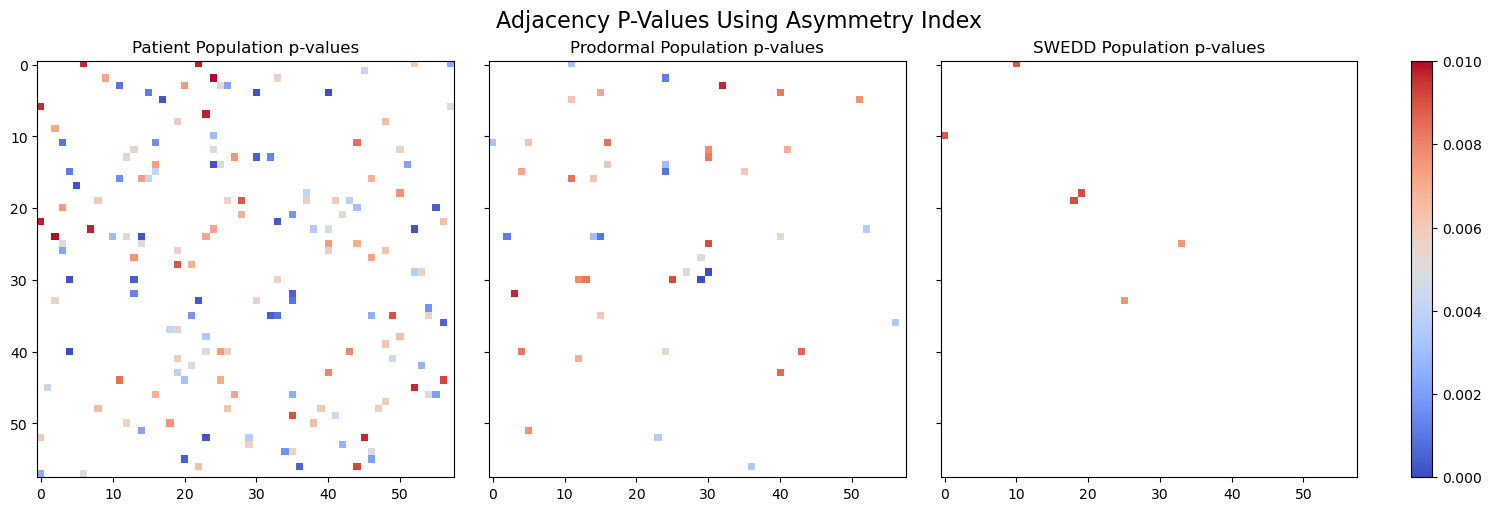

In [7]:
_, patient_p_val = statistical_testing(control_diff, patient_diff)
_, prodorm_p_val = statistical_testing(control_diff, prodorm_diff)
_, swedp_p_val = statistical_testing(control_diff, swedpd_diff)
print(f'Number of significant connections for patient: {np.sum(~np.isnan(patient_p_val))}')
print(f'Number of significant connections for prodormal: {np.sum(~np.isnan(prodorm_p_val))}')
print(f'Number of significant connections for SWEDD: {np.sum(~np.isnan(swedp_p_val))}')
# Determine the global vmin and vmax for consistent color scaling
vmin = 0
vmax = 1-CONFIDENCE
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True, constrained_layout=True)
# Add a title to the figure
fig.suptitle('Adjacency P-Values Using Asymmetry Index', fontsize=16)
# Plot control_diff
im0 = axs[0].imshow(patient_p_val, vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[0].set_title('Patient Population p-values')
# Plot patient_diff
im1 = axs[1].imshow(prodorm_p_val, vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[1].set_title('Prodormal Population p-values')
# Plot prodorm_diff
im2 = axs[2].imshow(swedp_p_val, vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[2].set_title('SWEDD Population p-values')
# Create a single color bar for all subplots
cbar = fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
# Show the plot
plt.show()

Difference Matrices Using Asymmetry Index
2nd percentile: -5.362198601289066, 98th percentile: 5.320156457583559


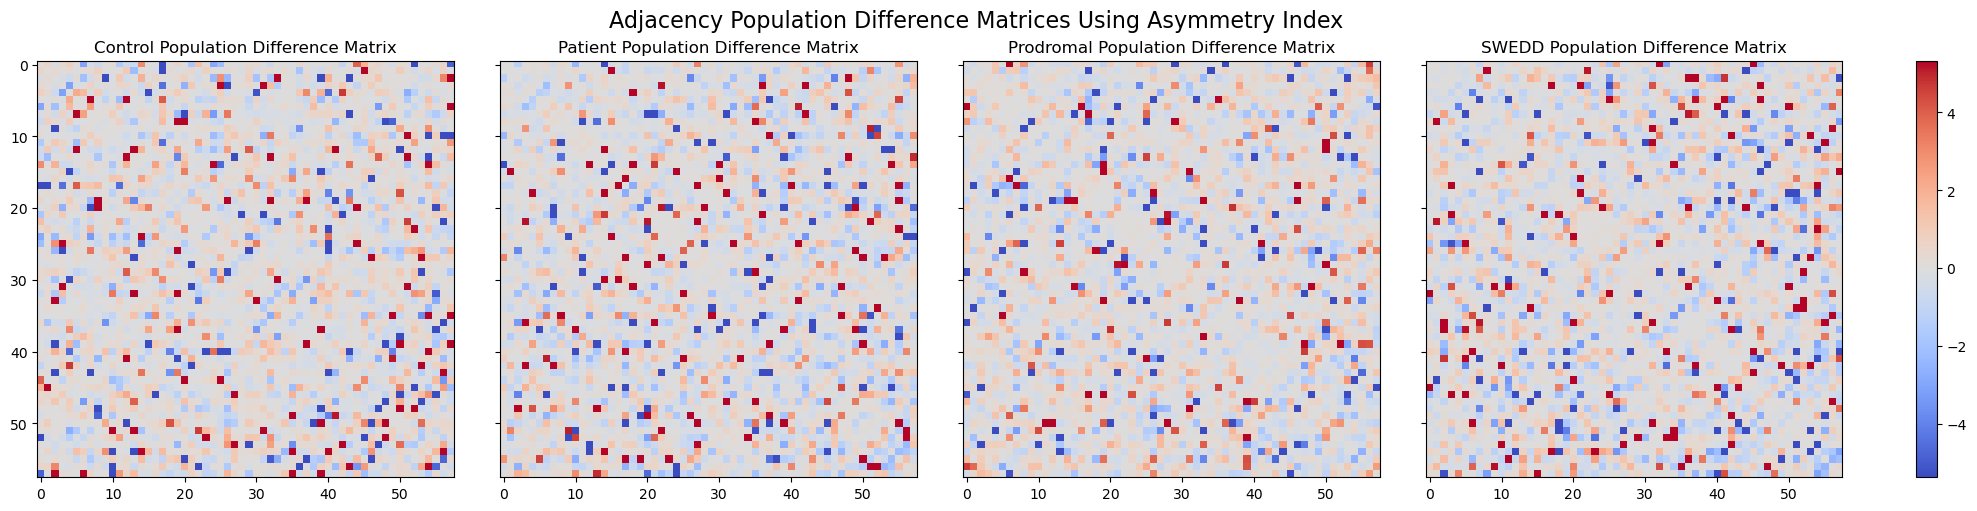

In [8]:
print(f'Difference Matrices Using Asymmetry Index')
# Calculate the mean and standard deviation of all matrices
all_matrices = np.concatenate([control_diff, patient_diff, prodorm_diff, swedpd_diff], axis=0)
mean_val = np.mean(all_matrices)
std_val = np.std(all_matrices)

# Calculate percentiles
vmin = np.percentile(all_matrices, 2)
vmax = np.percentile(all_matrices, 98)

# Print information
print(f'2nd percentile: {vmin}, 98th percentile: {vmax}')

# Plotting code
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True, constrained_layout=True)
# Add a title to the figure
fig.suptitle('Adjacency Population Difference Matrices Using Asymmetry Index', fontsize=16)
im0 = axs[0].imshow(control_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[0].set_title('Control Population Difference Matrix')
im1 = axs[1].imshow(patient_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[1].set_title('Patient Population Difference Matrix')
im2 = axs[2].imshow(prodorm_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[2].set_title('Prodromal Population Difference Matrix')
im3 = axs[3].imshow(swedpd_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[3].set_title('SWEDD Population Difference Matrix')
cbar = fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

# Show the plot
plt.show()

In [9]:
control_diff = np.array([compute_difference_matrix(m) for m in control])
patient_diff = np.array([compute_difference_matrix(m) for m in patient])
prodorm_diff = np.array([compute_difference_matrix(m) for m in prodorm])
swedpd_diff = np.array([compute_difference_matrix(m) for m in swedpd])

Number of significant connections for patient: 22
Number of significant connections for prodormal: 24
Number of significant connections for SWEDD: 44


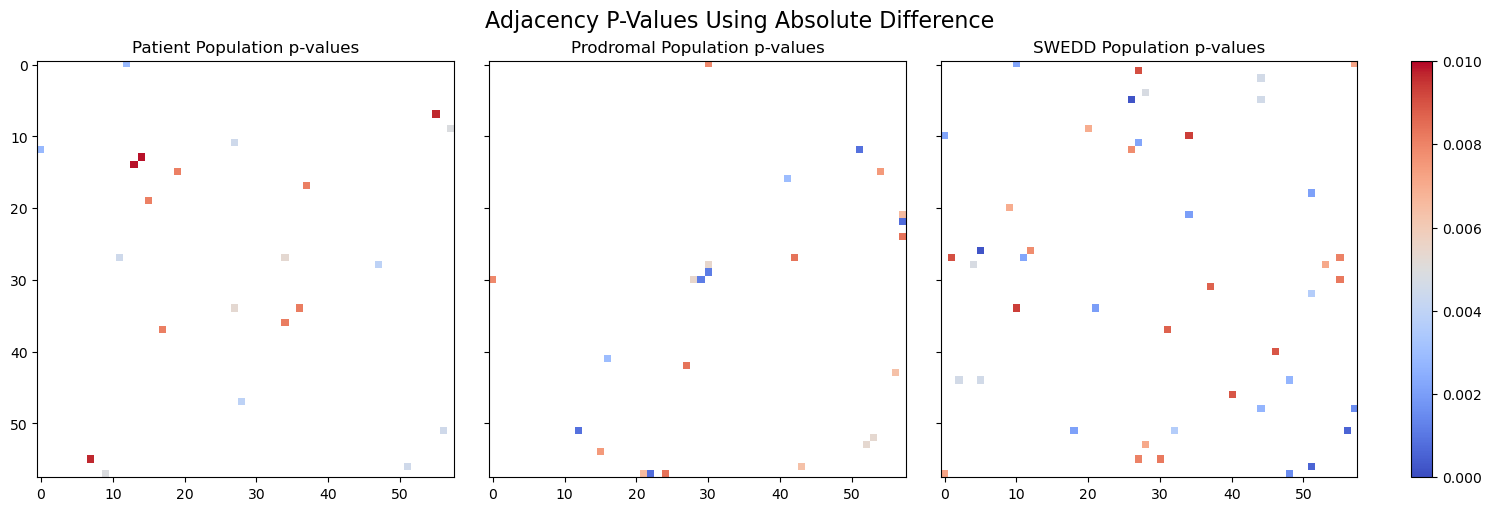

In [10]:
_, patient_p_val = statistical_testing(control_diff, patient_diff)
_, prodorm_p_val = statistical_testing(control_diff, prodorm_diff)
_, swedp_p_val = statistical_testing(control_diff, swedpd_diff)
print(f'Number of significant connections for patient: {np.sum(~np.isnan(patient_p_val))}')
print(f'Number of significant connections for prodormal: {np.sum(~np.isnan(prodorm_p_val))}')
print(f'Number of significant connections for SWEDD: {np.sum(~np.isnan(swedp_p_val))}')
# Determine the global vmin and vmax for consistent color scaling
vmin = 0
vmax = 1-CONFIDENCE
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True, constrained_layout=True)
# Add a title to the figure
fig.suptitle('Adjacency P-Values Using Absolute Difference', fontsize=16)
# Plot control_diff
im0 = axs[0].imshow(patient_p_val, vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[0].set_title('Patient Population p-values')
# Plot patient_diff
im1 = axs[1].imshow(prodorm_p_val, vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[1].set_title('Prodromal Population p-values')
# Plot prodorm_diff
im2 = axs[2].imshow(swedp_p_val, vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[2].set_title('SWEDD Population p-values')
# Create a single color bar for all subplots
cbar = fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
# Show the plot
plt.show()

Difference Matrices Using Absolute Difference
Mean: 0.39191744622679836, Std: 0.3731206743013129
vmin: -0.35432390237582745, vmax: 1.1381587948294243


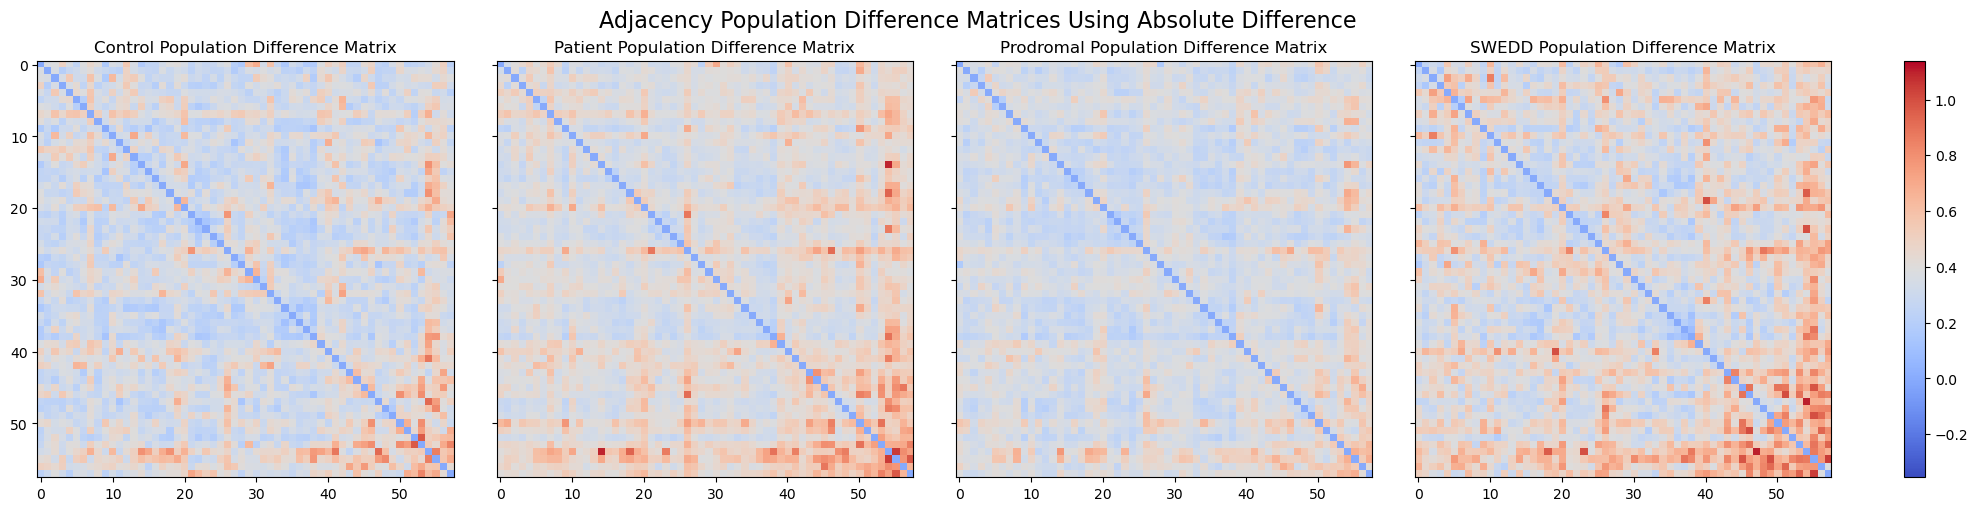

In [11]:
print(f'Difference Matrices Using Absolute Difference')

# Calculate the mean and standard deviation of all matrices
all_matrices = np.concatenate([control_diff, patient_diff, prodorm_diff, swedpd_diff], axis=0)
mean_val = np.mean(all_matrices)
std_val = np.std(all_matrices)


# Set vmin and vmax to mean ± 2 * std (or another factor)
vmin = mean_val - 2 * std_val
vmax = mean_val + 2 * std_val

# Print information
print(f'Mean: {mean_val}, Std: {std_val}')
print(f'vmin: {vmin}, vmax: {vmax}')
# Plotting code
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True, constrained_layout=True)
# Add a title to the figure
fig.suptitle('Adjacency Population Difference Matrices Using Absolute Difference', fontsize=16)
im0 = axs[0].imshow(control_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm') 
axs[0].set_title('Control Population Difference Matrix')
im1 = axs[1].imshow(patient_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[1].set_title('Patient Population Difference Matrix')
im2 = axs[2].imshow(prodorm_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[2].set_title('Prodromal Population Difference Matrix')
im3 = axs[3].imshow(swedpd_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[3].set_title('SWEDD Population Difference Matrix')
cbar = fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

# Show the plot
plt.show()

In [12]:
import torch
DATASET_PATH = '../data/ppmi_w_curv.pth'
dataset = torch.load(DATASET_PATH)
dataset.keys()

dict_keys(['data', 'class_label', 'id', 'curvatures'])

In [13]:
curvatures = dataset['curvatures'].numpy()
curvatures = standardize_matrices(curvatures)
curvatures.shape

(209, 116, 116)

In [14]:
control = curvatures[labels == 0]
prodorm = curvatures[labels == 1]
patient = curvatures[labels == 2]
swedpd = curvatures[labels == 3]
control.shape, patient.shape, prodorm.shape, swedpd.shape

((15, 116, 116), (113, 116, 116), (67, 116, 116), (14, 116, 116))

In [15]:
control_diff = np.array([compute_difference_matrix(m, method='index') for m in control])
patient_diff = np.array([compute_difference_matrix(m, method='index') for m in patient])
prodorm_diff = np.array([compute_difference_matrix(m, method='index') for m in prodorm])
swedpd_diff = np.array([compute_difference_matrix(m, method='index') for m in swedpd])

Number of significant connections for patient: 128
Number of significant connections for prodormal: 40
Number of significant connections for SWEDD: 10


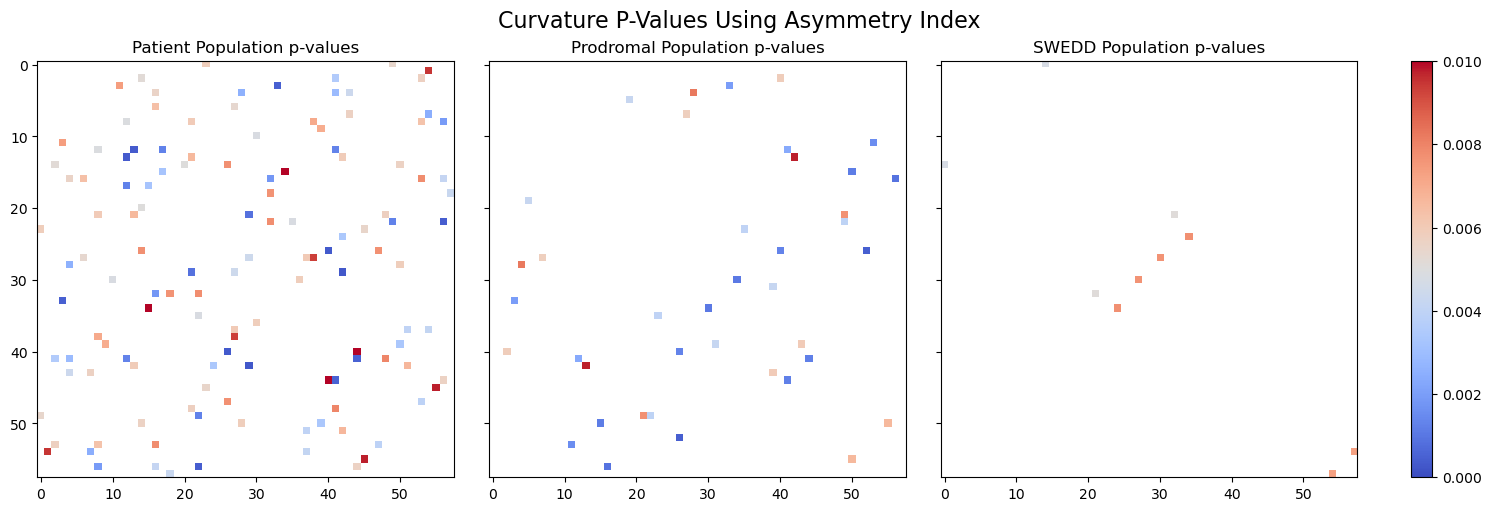

In [16]:
_, patient_p_val = statistical_testing(control_diff, patient_diff)
_, prodorm_p_val = statistical_testing(control_diff, prodorm_diff)
_, swedp_p_val = statistical_testing(control_diff, swedpd_diff)
print(f'Number of significant connections for patient: {np.sum(~np.isnan(patient_p_val))}')
print(f'Number of significant connections for prodormal: {np.sum(~np.isnan(prodorm_p_val))}')
print(f'Number of significant connections for SWEDD: {np.sum(~np.isnan(swedp_p_val))}')
# Determine the global vmin and vmax for consistent color scaling
vmin = 0
vmax = 1-CONFIDENCE
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True, constrained_layout=True)
# Add a title to the figure
fig.suptitle('Curvature P-Values Using Asymmetry Index', fontsize=16)
# Plot control_diff
im0 = axs[0].imshow(patient_p_val, vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[0].set_title('Patient Population p-values')
# Plot patient_diff
im1 = axs[1].imshow(prodorm_p_val, vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[1].set_title('Prodromal Population p-values')
# Plot prodorm_diff
im2 = axs[2].imshow(swedp_p_val, vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[2].set_title('SWEDD Population p-values')
# Create a single color bar for all subplots
cbar = fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
# Show the plot
plt.show()

Difference Matrices Using Asymmetry Index
2nd percentile: -10.75634697887207, 98th percentile: 10.57982954459418


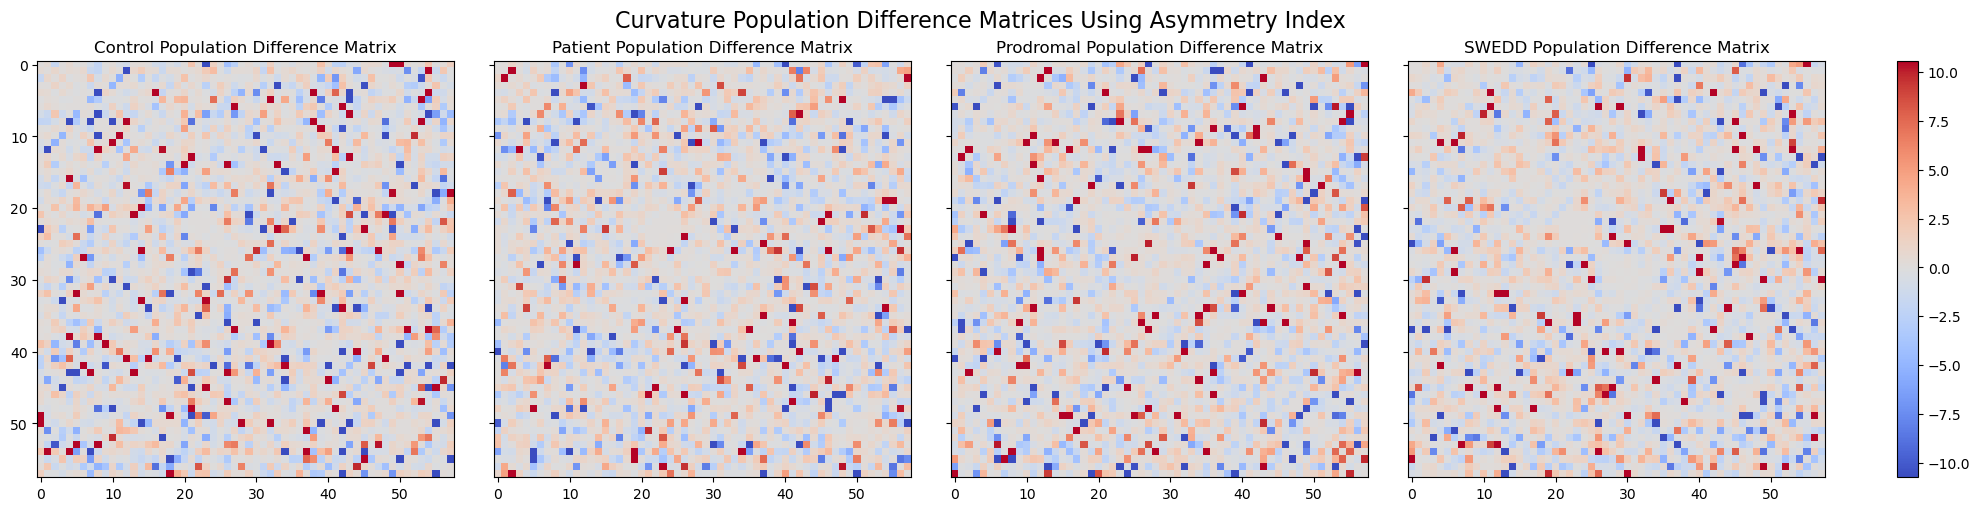

In [17]:
print(f'Difference Matrices Using Asymmetry Index')
# Calculate the mean and standard deviation of all matrices
all_matrices = np.concatenate([control_diff, patient_diff, prodorm_diff, swedpd_diff], axis=0)
mean_val = np.mean(all_matrices)
std_val = np.std(all_matrices)

# Calculate percentiles
vmin = np.percentile(all_matrices, 2)
vmax = np.percentile(all_matrices, 98)

# Print information
print(f'2nd percentile: {vmin}, 98th percentile: {vmax}')

# Plotting code
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True, constrained_layout=True)
# Add a title to the figure
fig.suptitle('Curvature Population Difference Matrices Using Asymmetry Index', fontsize=16)
im0 = axs[0].imshow(control_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[0].set_title('Control Population Difference Matrix')
im1 = axs[1].imshow(patient_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[1].set_title('Patient Population Difference Matrix')
im2 = axs[2].imshow(prodorm_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[2].set_title('Prodromal Population Difference Matrix')
im3 = axs[3].imshow(swedpd_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[3].set_title('SWEDD Population Difference Matrix')
cbar = fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

# Show the plot
plt.show()

In [18]:
control_diff = np.array([compute_difference_matrix(m) for m in control])
patient_diff = np.array([compute_difference_matrix(m) for m in patient])
prodorm_diff = np.array([compute_difference_matrix(m) for m in prodorm])
swedpd_diff = np.array([compute_difference_matrix(m) for m in swedpd])

Number of significant connections for patient: 18
Number of significant connections for prodormal: 112
Number of significant connections for SWEDD: 37


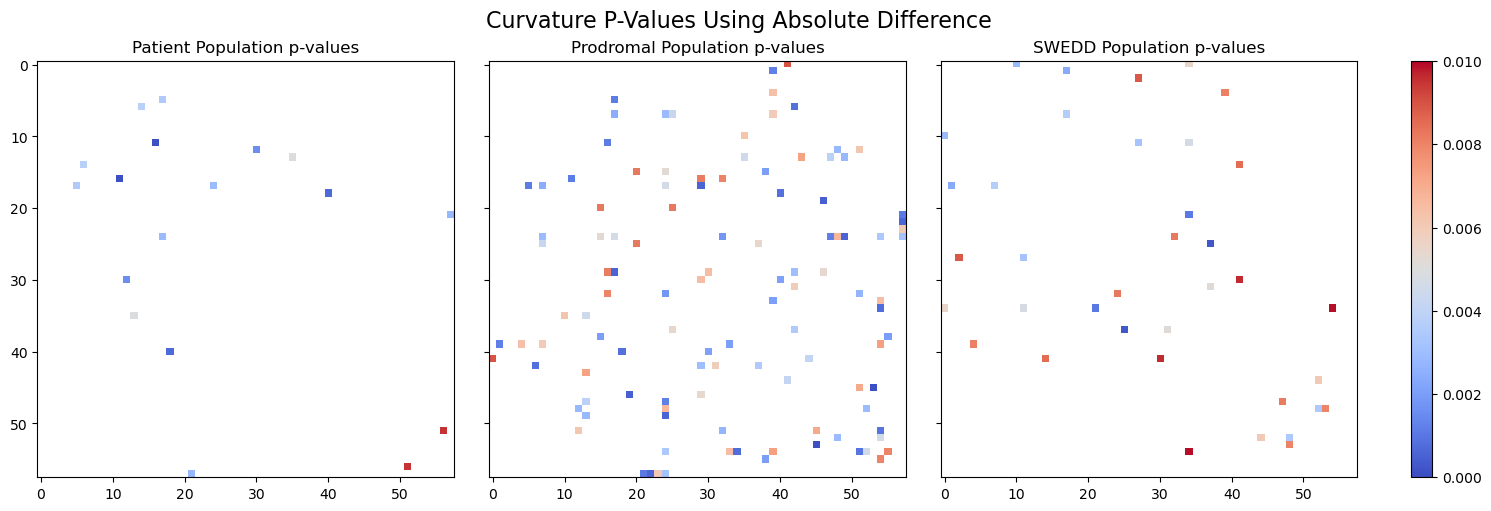

In [19]:
_, patient_p_val = statistical_testing(control_diff, patient_diff)
_, prodorm_p_val = statistical_testing(control_diff, prodorm_diff)
_, swedp_p_val = statistical_testing(control_diff, swedpd_diff)
print(f'Number of significant connections for patient: {np.sum(~np.isnan(patient_p_val))}')
print(f'Number of significant connections for prodormal: {np.sum(~np.isnan(prodorm_p_val))}')
print(f'Number of significant connections for SWEDD: {np.sum(~np.isnan(swedp_p_val))}')
# Determine the global vmin and vmax for consistent color scaling
vmin = 0
vmax = 1-CONFIDENCE
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True, constrained_layout=True)
# Add a title to the figure
fig.suptitle('Curvature P-Values Using Absolute Difference', fontsize=16)
# Plot control_diff
im0 = axs[0].imshow(patient_p_val, vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[0].set_title('Patient Population p-values')
# Plot patient_diff
im1 = axs[1].imshow(prodorm_p_val, vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[1].set_title('Prodromal Population p-values')
# Plot prodorm_diff
im2 = axs[2].imshow(swedp_p_val, vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[2].set_title('SWEDD Population p-values')
# Create a single color bar for all subplots
cbar = fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
# Show the plot
plt.show()

Difference Matrices Using Absolute Difference
Mean: 0.7322064078961733, Std: 0.6689026344510933
vmin: -0.6055988610060133, vmax: 2.07001167679836


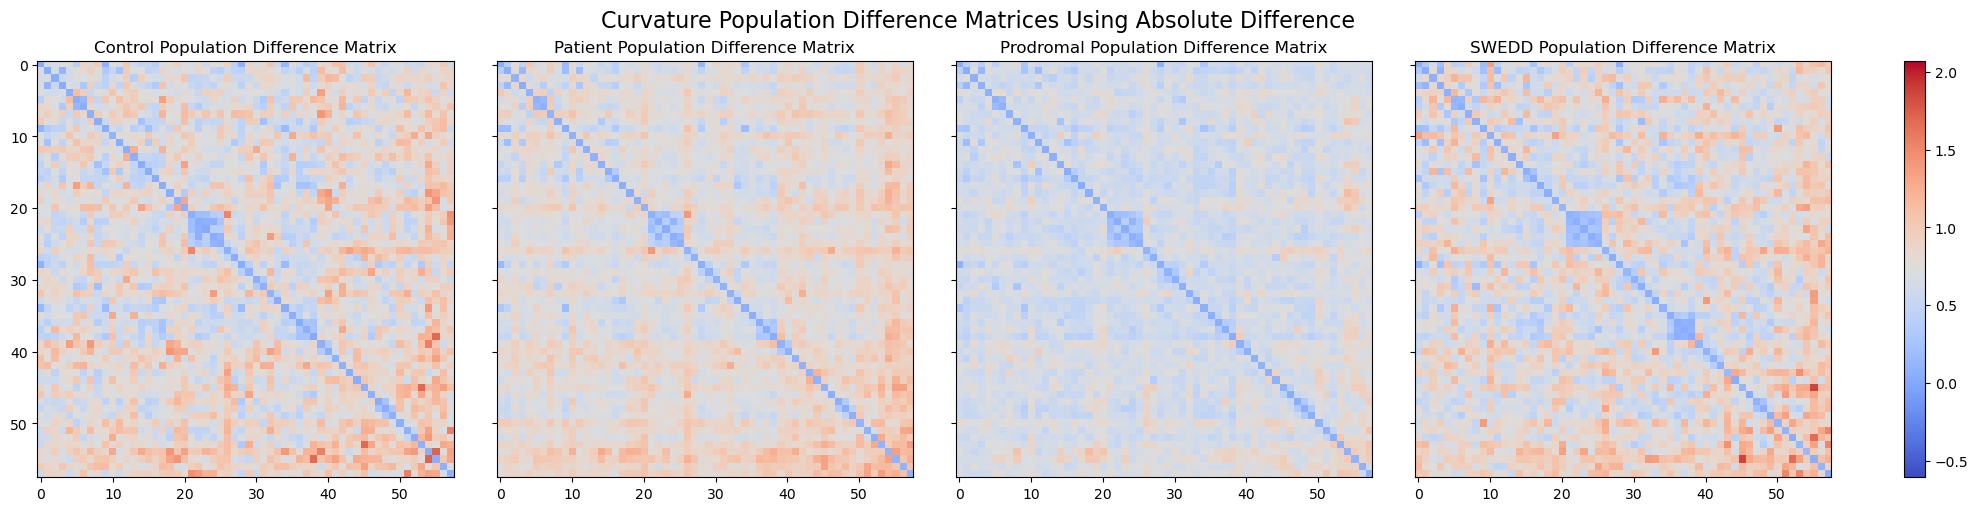

In [20]:
print(f'Difference Matrices Using Absolute Difference')

# Calculate the mean and standard deviation of all matrices
all_matrices = np.concatenate([control_diff, patient_diff, prodorm_diff, swedpd_diff], axis=0)
mean_val = np.mean(all_matrices)
std_val = np.std(all_matrices)


# Set vmin and vmax to mean ± 2 * std (or another factor)
vmin = mean_val - 2 * std_val
vmax = mean_val + 2 * std_val

# Print information
print(f'Mean: {mean_val}, Std: {std_val}')
print(f'vmin: {vmin}, vmax: {vmax}')
# Plotting code
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True, constrained_layout=True)
# Add a title to the figure
fig.suptitle('Curvature Population Difference Matrices Using Absolute Difference', fontsize=16)
im0 = axs[0].imshow(control_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[0].set_title('Control Population Difference Matrix')
im1 = axs[1].imshow(patient_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[1].set_title('Patient Population Difference Matrix')
im2 = axs[2].imshow(prodorm_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[2].set_title('Prodromal Population Difference Matrix')
im3 = axs[3].imshow(swedpd_diff.mean(axis=0), vmin=vmin, vmax=vmax, cmap='coolwarm')
axs[3].set_title('SWEDD Population Difference Matrix')
cbar = fig.colorbar(im0, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

# Show the plot
plt.show()